In [25]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model evaluations
from sklearn.model_selection import train_test_split

# Models from Scikit-Learn
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")#, category=DeprecationWarning)

In [2]:
df=pd.read_csv(r'G:\data 2\Fraud Detection/Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
#To check for null values
df.isna().sum()
# dataset is clean as we get no null values

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<AxesSubplot:xlabel='amount'>

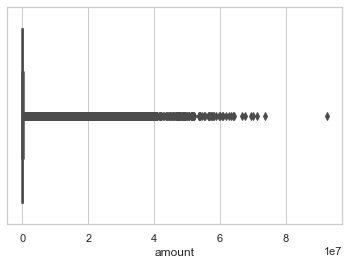

In [6]:
#outlier detection
sns.set_theme(style="whitegrid")
sns.boxplot(x=df["amount"])

In [7]:
(df["isFraud"] == 1).sum(), (df["isFraud"] == 0).sum(), (df["isFlaggedFraud"] == 1).sum()

(8213, 6354407, 16)

In [8]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

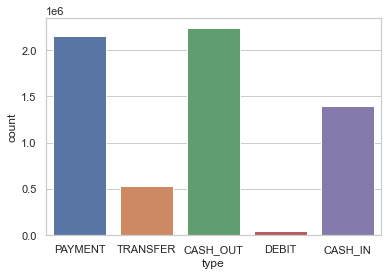

In [9]:
df.type.value_counts()
sns.countplot(df.type)

In [10]:
# Explore correlations to label
df.corr().isFraud.sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

<AxesSubplot:>

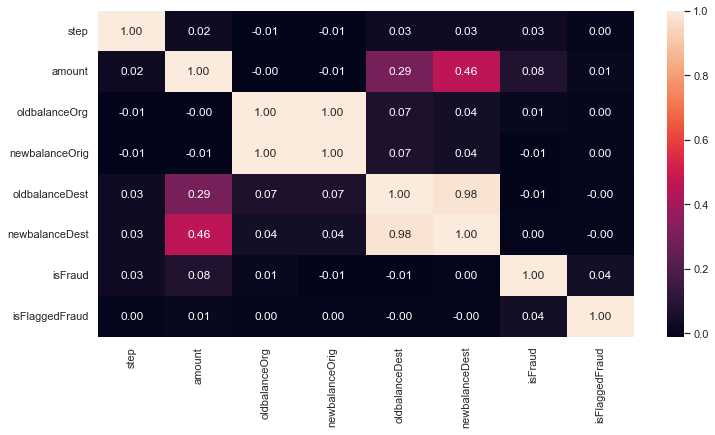

In [11]:
#Correlations
f, ax = plt.subplots(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [12]:
 {columns: len(df[columns].unique())for columns in df.columns}


{'step': 743,
 'type': 5,
 'amount': 5316900,
 'nameOrig': 6353307,
 'oldbalanceOrg': 1845844,
 'newbalanceOrig': 2682586,
 'nameDest': 2722362,
 'oldbalanceDest': 3614697,
 'newbalanceDest': 3555499,
 'isFraud': 2,
 'isFlaggedFraud': 2}

In [13]:
#Most frequent type of fraud transaction
print(df[df.amount<=0]['type'].value_counts().index[0])

CASH_OUT


In [14]:
df_freqFraud = df[df.isFlaggedFraud==1]
print(df_freqFraud['type'].value_counts().index[0])


TRANSFER


In [15]:
print("No of Valid transactions:",df.isFraud.value_counts()[0],':',round(df.isFraud.value_counts()[0]/df.shape[0] * 100,2),'%')
print("No of Fraud transactions:",df.isFraud.value_counts()[1],':',round(df.isFraud.value_counts()[1]/df.shape[0] * 100,2),'%')

No of Valid transactions: 6354407 : 99.87 %
No of Fraud transactions: 8213 : 0.13 %


In [16]:
#Error or difference in balance at origin and destination after transaction
df['difforig'] = (df["oldbalanceOrg"] - df["amount"] != df["newbalanceOrig"]).astype(int)
df['diffdest'] = (df["oldbalanceDest"] + df["amount"] != df["newbalanceDest"]).astype(int)

print("At origin:",round(df['difforig'].value_counts()[1]/df.shape[0] * 100,2),'%')
print("At the destination:",round(df['diffdest'].value_counts()[1]/df.shape[0] * 100,2),'%')

At origin: 85.09 %
At the destination: 74.45 %


In [17]:
#Removing these two as these are the transactions that produce most fraudulent transactions
df= df.loc[(df['type'].isin(['TRANSFER', 'CASH_OUT']))]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,difforig,diffdest
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,1,1
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1,1
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,1


In [18]:
#Not relevant features as name of orig and dest are of no help to us
df.drop(['step','nameOrig','nameDest','difforig','diffdest','isFlaggedFraud'],axis=1,inplace=True)
df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [19]:
df1=df.copy()

In [20]:
#Converting data to numerical values
label = LabelEncoder()
df1.type = label.fit_transform(df.type)

In [21]:
#train-test-splitting
X = df1.drop(["isFraud"],axis=1)
y = df1['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2216327, 6), (554082, 6), (2216327,), (554082,))

In [23]:
#Model building using pipeline
logreg_cv= LogisticRegression(solver='liblinear',random_state=42)
dt_cv=DecisionTreeClassifier(random_state=42)
knn_cv=KNeighborsClassifier()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN'}
cv_models=[logreg_cv,dt_cv,knn_cv]




In [24]:
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.997408324721331
Decision Tree Test Accuracy: 0.9993845673682198
KNN Test Accuracy: 0.9989351751672556
